In [ ]:
import os
import subprocess

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import scipy.io
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from torchsummary import summary

import gdown

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset is located at: https://drive.google.com/open?id=18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg

To download dataset directly to Colab environment, we need to set up gdown and p7zip. To download uncomment the next code.

In [ ]:
#!pip install --upgrade gdown
#!apt install p7zip-full -y

#Data Preprocessing

In [ ]:
def download_dataset(file_ids, download_folder, password):

    os.makedirs(download_folder, exist_ok=True)

    for filename, file_id in file_ids.items():
        file_path = os.path.join(download_folder, filename)
        gdown.download(id=file_id, output=file_path, quiet=False)

    print("Downloaded files: ", os.listdir(download_folder))

    #unzip
    subprocess.run(["7z", "x", f"{download_folder}/sv_data.zip", f"-o{download_folder}/unzipped", f"-p{password}", "-y"], check=True)

    extracted_path = os.path.join(download_folder, "unzipped", "sv_data")
    print("Filed unzip to: ", extracted_path)

    return (extracted_path)


In [ ]:
file_ids = {
    "sv_data.z01": "1KK5802tW2fXJN-q9rj2yrJ8hZASItXe_",
    "sv_data.z02": "13s3RUeD4xsC3N2My8YxTkqymEAo_mmdt",
    "sv_data.z03": "1pTaaCSQ7KQxlFyoqwP7DUizbQFuopW_y",
    "sv_data.zip": "1fXAIAusPmSdnaO6IQgwzIp6BNPgTo0kv"
}

download_folder = "/content/archive_parts"
password = "d89551fd190e38"

data_path = download_dataset(file_ids, download_folder, password)

Downloading...
From (original): https://drive.google.com/uc?id=1KK5802tW2fXJN-q9rj2yrJ8hZASItXe_
From (redirected): https://drive.google.com/uc?id=1KK5802tW2fXJN-q9rj2yrJ8hZASItXe_&confirm=t&uuid=868f431e-41e9-488b-88a3-5c4e39930381
To: /content/archive_parts/sv_data.z01
100%|██████████| 734M/734M [02:58<00:00, 4.11MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=13s3RUeD4xsC3N2My8YxTkqymEAo_mmdt
From (redirected): https://drive.google.com/uc?id=13s3RUeD4xsC3N2My8YxTkqymEAo_mmdt&confirm=t&uuid=13809042-797d-4d3b-b2f0-ff0b63abe5de
To: /content/archive_parts/sv_data.z02
100%|██████████| 734M/734M [04:03<00:00, 3.02MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1pTaaCSQ7KQxlFyoqwP7DUizbQFuopW_y
From (redirected): https://drive.google.com/uc?id=1pTaaCSQ7KQxlFyoqwP7DUizbQFuopW_y&confirm=t&uuid=c3ebc7ce-29e6-4337-b5f3-f62a88065e3a
To: /content/archive_parts/sv_data.z03
100%|██████████| 734M/734M [00:20<00:00, 35.2MB/s]
Downloading...
From (original):

Downloaded files:  ['sv_data.z01', 'sv_data.z02', 'sv_data.z03', 'sv_data.zip']
Filed unzip to:  /content/archive_parts/unzipped/sv_data


In [ ]:
def load_annotations(data_path):

    model_file = os.path.join(data_path, "sv_make_model_name.mat")
    image_folder = os.path.join(data_path, "image")

    make_model_data = scipy.io.loadmat(model_file)

    data = []
    for surveillance_model_id in range(len(make_model_data["sv_make_model_name"])):
        make = make_model_data["sv_make_model_name"][surveillance_model_id, 0].item()

        model_image_folder = os.path.join(image_folder, str(surveillance_model_id))
        if os.path.exists(model_image_folder):
            for img_name in os.listdir(model_image_folder):
                img_path = os.path.join(str(surveillance_model_id), img_name)
                data.append([img_path, make])

    return pd.DataFrame(data, columns=["image_path", "make"])

In [ ]:
df = load_annotations(data_path)

Now then the data is loaded, we need to split it for train and test sets. To do so we will use the created files `test_surveillance.txt` and `train_surveillance.txt` which were created by original owners of the dataset for better data representation.

In addition, here we are splitting to validation set as well (fixed validation), to ensure that model performance is comparable across the epochs experiments.

In [ ]:
def split_dataset(df, data_path, val_ratio=0.2):
    # Load predefined train/test split files
    train_file = os.path.join(data_path, "train_surveillance.txt")
    test_file = os.path.join(data_path, "test_surveillance.txt")

    with open(train_file, "r") as f:
        train_images = {line.strip() for line in f.readlines()}

    with open(test_file, "r") as f:
        test_images = {line.strip() for line in f.readlines()}

    df["split"] = df["image_path"].apply(lambda x: "train" if x in train_images else ("test" if x in test_images else "other"))

    train_df = df[df["split"] == "train"].copy()
    test_df = df[df["split"] == "test"].copy()
    train_df, val_df = train_test_split(train_df, test_size=val_ratio, stratify=train_df["make"], random_state=42)

    train_df.drop(columns=["split"], inplace=True)
    val_df.drop(columns=["split"], inplace=True)
    test_df.drop(columns=["split"], inplace=True)

    return train_df, val_df, test_df


def show_random_samples(df, data_path, num_samples=6):

    samples = df.sample(n=num_samples).reset_index(drop=True)
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle("Random Car Samples from Training Set", fontsize=16)

    for i, ax in enumerate(axes.flat):
        img_path = os.path.join(data_path, "image", samples.loc[i, "image_path"])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        make = samples.loc[i, "make"]
        ax.imshow(image)
        ax.set_title(f"Make: {make}", fontsize=12)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


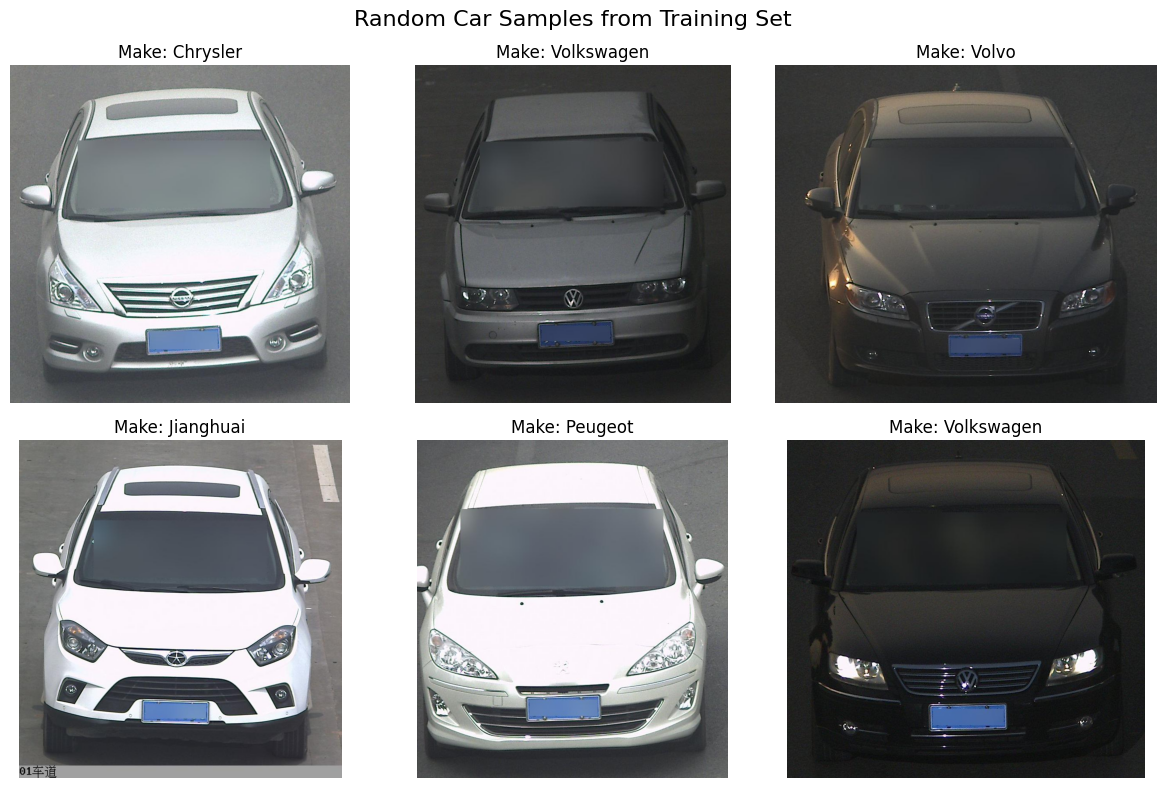

In [ ]:
train_df, val_df, test_df = split_dataset(df, data_path)

show_random_samples(train_df, data_path)

In [ ]:
def encode_labels(train_df, val_df, test_df):
    make_mapping = {name: idx for idx, name in enumerate(train_df["make"].unique())}

    train_df["make_label"] = train_df["make"].map(make_mapping)
    val_df["make_label"] = val_df["make"].map(make_mapping)
    test_df["make_label"] = test_df["make"].map(make_mapping)

    return train_df, val_df, test_df, make_mapping


def calculate_category_counts(train_df, val_df, test_df):

    train_counts = train_df["make"].value_counts().reset_index()
    train_counts.columns = ["make", "num_images_train"]

    val_counts = val_df["make"].value_counts().reset_index()
    val_counts.columns = ["make", "num_images_val"]

    test_counts = test_df["make"].value_counts().reset_index()
    test_counts.columns = ["make", "num_images_test"]

    category_counts = train_counts.merge(val_counts, on="make", how="outer").merge(
        test_counts, on="make", how="outer")

    category_counts.fillna(0, inplace=True)
    category_counts[["num_images_train", "num_images_val", "num_images_test"]] = category_counts[
        ["num_images_train", "num_images_val", "num_images_test"]
    ].astype(int)

    return category_counts


In [ ]:
train_df, val_df, test_df, make_mapping = encode_labels(train_df, val_df, test_df)

category_counts = calculate_category_counts(train_df, val_df, test_df)
category_counts_sorted = category_counts.sort_values(by="num_images_train", ascending=False)
display(HTML(category_counts_sorted.to_html()))

,make,num_images_train,num_images_val,num_images_test
61,Volkswagen,2526,632,1354
59,Toyota,1697,425,909
28,Honda,1151,288,616
5,Benz,924,231,493
2,BWM,917,229,492
44,MAZDA,864,216,462
47,Nissan,837,209,447
31,Hyundai,802,201,428
46,Mitsubishi,729,182,389
40,Lexus,627,157,336


Most represented class: Volkswagen (2526 train images)

Least represented class: Infiniti (12 train images)

Middle range: ~300-500 images per class

We need to balance the dataset without over-augmenting well-represented classes.



In [ ]:
def get_transforms(make, make_counts, threshold=500):

    base_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #ImageNet mean/std
    ]

    if make_counts[make] < threshold:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.RandomRotation(30),
            transforms.RandomAffine(degrees=15, shear=10),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
            *base_transforms
        ])
    else:
        return transforms.Compose(base_transforms)


In [ ]:
class CompCarsDataset(Dataset):

    def __init__(self, dataframe, root_dir, make_counts, threshold=500):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.make_counts = make_counts
        self.threshold = threshold

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, "image/", self.dataframe.iloc[idx]["image_path"])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = Image.fromarray(image)

        make = self.dataframe.iloc[idx]["make"]
        make_label = self.dataframe.iloc[idx]["make_label"]
        make_label = torch.tensor(make_label, dtype=torch.long)

        transform = get_transforms(make, self.make_counts, self.threshold)
        image = transform(image)

        return image, make_label


In [ ]:
make_counts = train_df["make"].value_counts().to_dict()

train_dataset = CompCarsDataset(train_df, data_path, make_counts, threshold=500)
val_dataset = CompCarsDataset(val_df, data_path, make_counts, threshold=100)
test_dataset = CompCarsDataset(test_df, data_path, make_counts, threshold=100)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_loader)} batches, Val: {len(val_loader)} batches, Test: {len(test_loader)} batches")


Train: 777 batches, Val: 195 batches, Test: 416 batches


In [ ]:
#Check that data is correct type
image, label = train_dataset[0]

print(f"Image Type: {type(image)}")
print(f"Image Shape: {image.shape}")
print(f"Label Type: {type(label)}")


Image Type: <class 'torch.Tensor'>
Image Shape: torch.Size([3, 224, 224])
Label Type: <class 'torch.Tensor'>


# Model Initialisation And Training Loop

In [ ]:
class CarMakeResNet(nn.Module):
    def __init__(self, num_classes):
        super(CarMakeResNet, self).__init__() #load pretrained model
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
num_classes = len(train_df["make"].unique())

#Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CarMakeResNet(num_classes=num_classes).to(device)

print("Classes:", num_classes)
print("Running on:", device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classes: 67
Running on: cuda


As we have class imbalance, we need to apply Focal Loss as a Loss function, because Cross Entropy tends to perform poorly in such a case.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        pt = torch.exp(-ce_loss)  #Get pt = e^(-CE Loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):

    model.to(device)

    best_val_loss = float("inf")
    epochs_no_improve = 0  #Counter for early stopping

    for epoch in range(num_epochs):
        #TRAINING
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Track loss and accuracy
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = 100 * correct_train / total_train
        avg_train_loss = total_train_loss / len(train_loader)

        #VALIDATION
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                #Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                #Track loss & accuracy
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = 100 * correct_val / total_val
        avg_val_loss = total_val_loss / len(val_loader)

        #EPOCH SUMMARY
        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"    Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"    Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

        #EARLY STOPPING
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0  # Reset counter
            torch.save(model.state_dict(), "best_car_make_resnet18.pth")  #Save best model
            print(f"Model improved, saving weights at epoch {epoch+1}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve}/{patience} epochs")

        if epochs_no_improve >= patience:
            print("Early stopping triggered! Restoring best model...")
            model.load_state_dict(torch.load("best_car_make_resnet18.pth"))  #Load best weights
            break

    return model



In [ ]:
num_epochs = 30
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


Epoch [1/30]:
    Train Loss: 0.9344, Train Accuracy: 73.68%
    Val Loss: 1.0977, Val Accuracy: 66.20%
--------------------------------------------------
Model improved, saving weights at epoch 1
Epoch [2/30]:
    Train Loss: 0.1476, Train Accuracy: 94.47%
    Val Loss: 0.6234, Val Accuracy: 75.19%
--------------------------------------------------
Model improved, saving weights at epoch 2
Epoch [3/30]:
    Train Loss: 0.0776, Train Accuracy: 96.68%
    Val Loss: 0.5217, Val Accuracy: 77.99%
--------------------------------------------------
Model improved, saving weights at epoch 3
Epoch [4/30]:
    Train Loss: 0.0564, Train Accuracy: 97.33%
    Val Loss: 0.4346, Val Accuracy: 80.21%
--------------------------------------------------
Model improved, saving weights at epoch 4
Epoch [5/30]:
    Train Loss: 0.0440, Train Accuracy: 98.00%
    Val Loss: 0.5637, Val Accuracy: 77.09%
--------------------------------------------------
No improvement for 1/5 epochs
Epoch [6/30]:
    Train Los

<ipython-input-49-8633e9d0d233>:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_car_make_resnet18.pth"))  #Load best weights


In [ ]:
save_path = "/content/drive/My Drive/car_make_resnet18.pth"

torch.save(trained_model.state_dict(), save_path)

print(f"Model saved to Google Drive: {save_path}")


Model saved to Google Drive: /content/drive/My Drive/car_make_resnet18.pth
